# Algorytm ewolucyjny

+ AUTOR: **ŁUKASZ STANISZEWSKI**
+ Zadanie: **Implementacja metody realizującej algorytm ewolucyjny bez krzyżowania z selekcją turniejową i sukcesją elitarną i jej badanie.**
+ POLECENIE: **[LINK](https://github.com/lukasz-staniszewski/ml-algorithms-scratch/blob/main/evolution-algorithm/task_pl.pdf)**


## Import bibliotek
+ **numpy** -> operacje na macierzach i wektorach
+ **math** -> funkcje matematyczne
+ **mplot3d** + **pyplot** -> wykresy
+ **copy** -> konieczna jest kopia w selekcji turniejowej
+ **statistics** -> liczenie średniej
+ **pandas** -> tworzenie tabel
+ **time** -> mierzenie czasu

In [19]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import statistics
import pandas as pd
import time
from typing import Callable, Tuple, List
from __future__ import annotations

## Zdefiniowanie funkcji
 

#### Funkcja 1
+ $f_1(x) = {\varphi(x,\mu_1,\Sigma_1) + \varphi(x,\mu_2,\Sigma_2) + \varphi(x,\mu_3,\Sigma_3)} $ 

+ $ \varphi(x,\mu,\Sigma)={e^{-0.5(x-\mu)^T\Sigma^{-1}(x-\mu)}\over \sqrt{(2\pi)^{dim(x)}|\Sigma|}} $

+ $ \mu_1=\begin{bmatrix} 14\\-11\end{bmatrix}, \mu_2=\begin{bmatrix} 10\\-10\end{bmatrix}, \mu_3=\begin{bmatrix} 7\\-13\end{bmatrix} $

+ $ \Sigma_1=\begin{bmatrix} 1.3&-0.5\\-0.5&0.8\end{bmatrix}, \Sigma_2=\begin{bmatrix} 1.7&0.4\\0.4&1.2\end{bmatrix}, \Sigma_3=\begin{bmatrix} 1&0\\0&1.5\end{bmatrix} $

In [20]:
mi1 = np.matrix([14, -11]).transpose()
mi2 = np.matrix([10, -10]).transpose()
mi3 = np.matrix([7, -13]).transpose()

Sigma1 = np.matrix([[1.3, -0.5],[-0.5, 0.8]])
Sigma2 = np.matrix([[1.7, 0.4],[0.4, 1.2]])
Sigma3 = np.matrix([[1, 0],[0, 1.5]])

def phi(x, mi, sigma):
    return math.exp(-0.5 * (x - mi).transpose() * np.linalg.inv(sigma) * (x-mi)) / (math.sqrt((2*math.pi)**2 * np.linalg.det(sigma)))

def f1(x):
    vector = np.matrix(x)
    if vector.shape[0] == 1:                                                       # allows to make a column vector as an imput
        vector = vector.transpose()
    return phi(vector, mi1, Sigma1) + phi(vector, mi2, Sigma2) + phi(vector, mi3, Sigma3)

def draw_function3D(function, functionName, minmax=25):
    fig = plt.figure(figsize=(7, 7))                                        # size of plot
    ax = fig.add_subplot(111, projection="3d")
    ax.set_position([0,0,0.95,1])
    x = y = np.arange(-minmax, minmax, 0.05)                                  # range of x and y
    X, Y = np.meshgrid(x, y)
    zs = np.array([function([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))]) # creating function values for x and y
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z, linewidth=0)                                     # creating plot
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')
    ax.set_title(functionName)                                                # setting plot title
    plt.show()

def draw_function_contour(function, minx=-25, maxx=25, miny=-25, maxy=25):
    plt.style.use('seaborn-white')
    x = np.linspace(minx, maxx, 500)
    y = np.linspace(miny, maxy, 500)
    X,Y = np.meshgrid(x, y)
    zs = np.array([function([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))]) # creating function values for x and y
    Z = zs.reshape(X.shape)
    ax = plt.contour(X,Y,Z, 3, colors='black')
    plt.clabel(ax, inline=True, fontsize=8)
    plt.imshow(Z, extent=[minx, maxx, miny, maxy], origin='lower', alpha = 0.5)
    plt.rcParams["figure.figsize"] = (12,8)
    plt.colorbar()

+ Dodatkowo wykres funkcji $f_1$ w 3D:

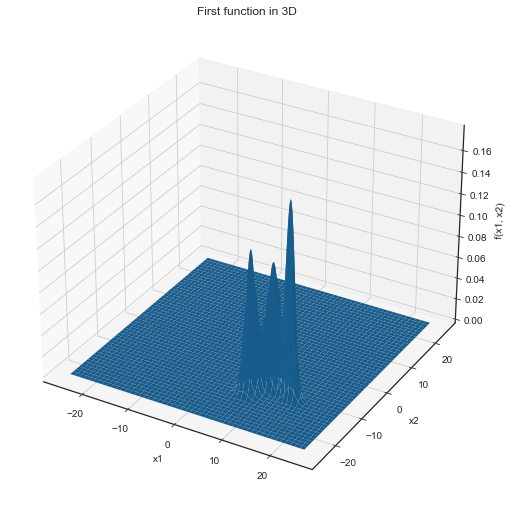

In [21]:
draw_function3D(f1, "First function in 3D")                                 # executing creating 3D function

+ Poziomicowy wykres funkcji $f_1$:

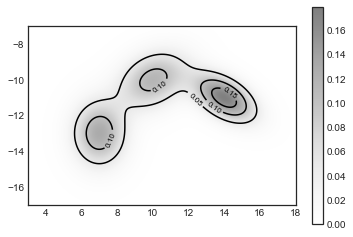

In [22]:
draw_function_contour(f1, 3, 18, -17, -7)

#### Funkcja 2
+ $f_2(x) = {-20 \cdot e^{-0.2 \cdot \sqrt{0.5 \cdot x^Tx}}-e^{0.5 \cdot (cos(2\pi x_1)+ cos(2\pi x_2))}+e+20} $

In [23]:
def f2(x):
    vector = np.matrix(x)
    if vector.shape[0] == 1:                                                       # allows to make a column vector as an imput
        vector = vector.transpose()
    x1 = vector.item(0)
    x2 = vector.item(1)
    return -20 * math.exp(-0.2*math.sqrt(0.5 * vector.transpose() * vector)) - math.exp(0.5 * (math.cos(2 * math.pi * x1) + math.cos(2 * math.pi * x2))) + math.e + 20

+ Dodatkowo wykres funkcji $ f_2 $ w 3D:

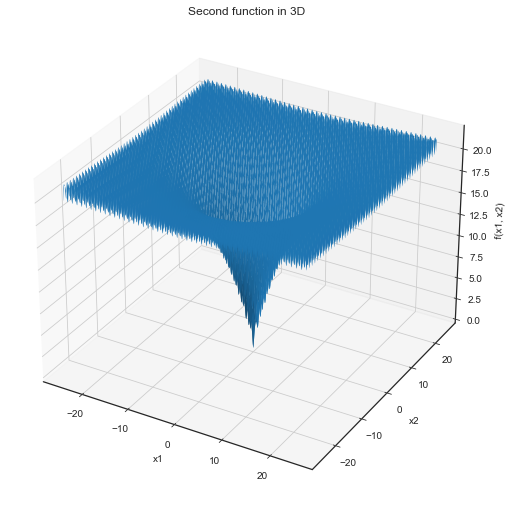

In [24]:
draw_function3D(f2, "Second function in 3D")

+ Poziomicowy wykres funkcji $f_2$:

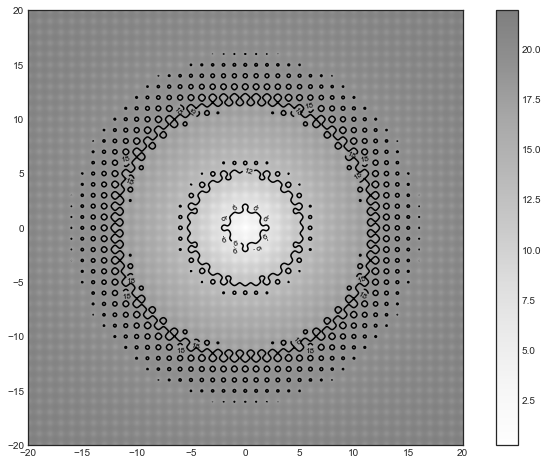

In [25]:
draw_function_contour(f2, -20, 20, -20, 20)

## Klasy

In [37]:
class Individual:
    """
    Individual class represents a single individual.
    """
    def __init__(self, x1: float, x2: float, f: Callable, mutation_stddev: float) -> None:
        """_summary_

        Args:
            x1 (float): 1st param of vector
            x2 (float): 2nd param of vector 
            f (Callable): evaluation function
            mutation_stddev (float): standard deviation of normal distribution for mutation
        """
        self.x1 = x1
        self.x2 = x2
        self.f = f
        self.mutation_stddev = mutation_stddev
        self.rating = None                                    # After performing iniciation there is no rating of individuals

    def rate_individual(self) -> None:
        """
        Rating specific individual.
        """
        self.rating = self.f([self.x1, self.x2])

    def mutate(self) -> None:
        """
        Mutates individual by adding to actual x1, x2 result of normal distribution with mean 0 and standard deviation = mutation_stddev.
        """
        new_x1 = self.x1 + np.random.normal(0, self.mutation_stddev)
        new_x2 = self.x2 + np.random.normal(0, self.mutation_stddev)
        self.x1 = new_x1
        self.x2 = new_x2

In [38]:
class Population:
    """
    Class Population represents a population.
    """
    def __init__(self, init_mean: float, init_stddev: float, population_sz: int, f: Callable, mutation_stddev: float, tournament_sz: int, is_max: bool) -> None:
        """_summary_

        Args:
            init_mean (float): mean for normal distribution in initialization
            init_stddev (float): standard deviation for normal distribution in initialization
            population_sz (int): size of population
            f (Callable): evaluation function
            mutation_stddev (float): standard deviation of normal distribution for mutation
            tournament_sz (int): size of tournament
            is_max (bool): if True, then the best individual is the one with the highest rating, otherwise the best individual is the one with the lowest rating
        """
        self.init_mean = init_mean
        self.init_stddev = init_stddev
        self.population_sz = population_sz
        self.f = f
        self.mutation_stddev = mutation_stddev
        self.tournament_sz = tournament_sz
        self.is_max = is_max
        self.population = []

    def initiate(self) -> None:
        """Initialize population.
        """
        for _ in range(self.population_sz):
            x1 = np.random.normal(self.init_mean, self.init_stddev)
            x2 = np.random.normal(self.init_mean, self.init_stddev)
            self.population.append(Individual(x1, x2, self.f, self.mutation_stddev)) 

    def rate_population(self) -> None:
        """Rates population.
        """
        for individual in self.population:
            individual.rate_individual()

    def sort_population(self) -> None:
        """Sorts individuals in population by their rating descending (if self.is_max is True) or ascending (otherwise).
        """
        self.population.sort(reverse=self.is_max, key=lambda pop: pop.rating)

    def function_mean(self) -> float:
        """Arithmetic avarage of individuals' ratings.
    
        Returns:
            float: mean of individuals' ratings
        """
        return statistics.mean([ind.rating for ind in self.population])

    def function_best(self) -> float:
        """Rating of best individual.
        

        Raises:
            Exception: when population is empty

        Returns:
            float: rating of best individual
        """
        if len(self.population) > 0:
            return self.population[0].rating
        else:
            raise Exception("There is no individual in population")

    def function_worst(self) -> float:
        """Rating of worst individual.
        

        Raises:
            Exception: when population is empty

        Returns:
            float: rating of worst individual
        """
        if len(self.population) > 0:
            return self.population[len(self.population)-1].rating
        else:
            raise Exception("There is no individual in population")

    def mutate_population(self) -> None:
        """Mutates individuals.
        """
        for individual in self.population:
            individual.mutate()

    def select_tournament(self) -> Population:
        """Performs tournament selection by creating empty population and adding to it winners of tournamets.
        
        Returns:
            Population: new Population as a result of tournament selection
        """
        selected_individuals = Population(self.init_mean, self.init_stddev, self.population_sz, self.f, self.mutation_stddev, self.tournament_sz, self.is_max)
        for _ in range(self.population_sz):                           
            tournament_players = np.random.randint(0, self.population_sz, self.tournament_sz)  
            selected_individuals.population.append(copy.deepcopy(self.population[min(tournament_players)]))
        return selected_individuals

    def success_elite(self, selected_individuals: Population, elite_success_param: int) -> None:
        """Performs elite success from given population and population selected.
        
        Args:
            selected_individuals (Population): individuals from which success is performed
            elite_success_param (int): same as k = elite success
        """
        self.population = self.population[:len(self.population) - elite_success_param]
        self.population.extend(selected_individuals.population[:elite_success_param])

## Algorytm ewolucyjny
#### Pseudokod:

In [39]:
# Evolution_Algorithm(parameters):
#   INITIATE(P0)
#   RATE_AND_SORT(P0)
#   WHILE(!STOP_CRITERIUM):
#      Tt = TOURNAMENT_SELECTION(Pt)
#      MUTATE(Tt)
#      RATE_AND_SORT(Tt)
#      Pt+1 = ELITE_SUCCESS(Pt, Tt)
#      SORT(Pt+1)

#### Kod:
+ Parametry funkcji:
    + **is_maximalization** -> ustawione na _True_ maksymalizuje dana funkcje, na _False_ - minimalizuje  
    + **init_mean** -> definicja średniej dla rozkładu normalnego w przypadku inicjacji populacji 
    + **init_deviation** -> definicja odchylenia standardowego dla rozkładu normalnego w przypadku inicjacji populacji 
    + **s_of_population** -> rozmiar populacji
    + **func_name** -> nazwa funkcji, która będzie optymalizowana 
    + **mut_dev** -> odchylenie standarowe rozkładu normalnego dla mutacji
    + **s_of_tournament** -> rozmiar turnieju dla selekcji turniejowej
    + **elite_success_param** -> parametr k dla sukcesji turniejowej 
    + **budget** -> maksymalna liczba osobników dla których zostanie wykonana ocena
+ Funkcja zwraca populację ostateczną

In [40]:
def evolution_alg(is_max: bool, init_mean: float, init_stddev: float, population_sz: int, f: Callable, mutation_stddev: float, tournament_sz: int, elite_success: int, budget: int) -> Population:
    """Performs evolution algorithm.

    Args:
        is_max (bool): if True, then the best individual is the one with the highest rating, otherwise the best individual is the one with the lowest rating
        init_mean (float): mean for normal distribution in initialization
        init_stddev (float): standard deviation for normal distribution in initialization
        population_sz (int): size of population
        f (Callable): evaluation function
        mutation_stddev (float): standard deviation of normal distribution for mutation
        tournament_sz (int): size of tournament
        elite_success (int): same as k = elite success
        budget (int): max number of individuals, for which rating is performed

    Returns:
        Population: final population
    """
    population = Population(init_mean, init_stddev, population_sz, f, mutation_stddev, tournament_sz, is_max)
    population.initiate()                                                    # INITAITE(P0)
    number_of_rates = 0
    population.rate_population()                                             # RATE(P0)
    population.sort_population()                                             # SORT(P0)
    number_of_rates += population.population_sz                              # by rating full population, algorithm performs s_of_population rates
    while number_of_rates + population.population_sz <= budget:              # STOP CRITERIUM
        selected_population = population.select_tournament()                 # Tt = TOURNAMENT_SELECTION(Pt)
        selected_population.mutate_population()                              # MUTATE (Tt)
        selected_population.rate_population()                                # RATE(Tt)
        selected_population.sort_population()                                # SORT(Tt)
        number_of_rates += len(selected_population.population)
        population.success_elite(selected_population, elite_success)   # Pt+1 = ELITE_SUCCESS(Pt, Tt)
        population.sort_population()                                         # SORT(Pt+1)
    return population

## Optymalizacja funkcji
#### Sformułowanie problemu
+ koniecznym jest znalezienie parametrów algorytmu w celu optymalizacji danej funkcji tak, aby średnia funkcji dla populacji była lepsza niż wartość progowa dla podanego budżetu i dla conajmniej 4 z 7 użytych ziaren dla generatora liczb pseudolosowych
+ założenie: ziarna = {1, 10, 100, 300, 500, 1000, 5000}

In [41]:
seeds = [1, 10, 100, 300, 500, 1000, 5000]

#### Funkcja $ f_1 $
+ narzucone parametry:
    + **rozkład normalny początkowy** = N(0,1) (init_mean = 0, init_deviation = 0)
    + **maksymalizacja** (is_maximilzation = True)
    + **funkcja** = f1 (func_name=f1)
    + **budżet** = $ 10^6 $ (budget = 1.000.000)
    + **próg** = 0.15 (treshold = 0.15)
    
+ założone parametry:
    + **rozmiar populacji** = 100 (s_of_population = 100)
    + **odchylenie standardowe mutacji** = 1 (mut_dev = 1)
    + **rozmiar turnieju** = 2 (s_of_tournament = 2)
    + **parametr sukcesji elitarnej** = 1 (elite_success_param = 1)

+ symulacje:

In [42]:
result_populations_f1 = []
for seed in seeds:
    np.random.seed(seed)
    result_populations_f1.append(evolution_alg(True, 0, 1, 100, f1, 1, 2, 1, 1000000))

+ Zestawienie tabelowe czy są lepsze od progu:

In [43]:
treshold_f1 = 0.15
f1_results = {}
f1_results["seeds"] = seeds
f1_results["mean"] = [round(population.function_mean(),4) for population in result_populations_f1]
f1_results["treshold"] = [treshold_f1 for _ in range(len(seeds))]
f1_results["is_better"] = [population.function_mean() > treshold_f1 for population in result_populations_f1]
df1 = pd.DataFrame(f1_results)
df1.set_index("seeds")

,mean,treshold,is_better
seeds,,,
1,0.1792,0.15,True
10,0.1792,0.15,True
100,0.1307,0.15,False
300,0.1792,0.15,True
500,0.1792,0.15,True
1000,0.1307,0.15,False
5000,0.1792,0.15,True


+ jak widać w 5 symulacjach na 7 udało się doprowadzić do populacji, dla której średnia wartość funkcji jest lepsza niż próg (większa niż 0.15)
+ uznane są więc te parametry za odpowiednie

#### Funkcja $ f_2 $
+ narzucone parametry:
    + **rozkład normalny początkowy** = N(3,1) (init_mean = 3, init_deviation = 1)
    + **minimalizacja** (is_maximilzation = False)
    + **funkcja** = f2 (func_name=f2)
    + **budżet** = $ 10^5 $ (budget = 100.000)
    + **próg** = 1 (treshold = 1)
    
+ założone parametry:
    + **rozmiar populacji** = 100 (s_of_population = 100)
    + **odchylenie standardowe mutacji** = 1 (mut_dev = 1)
    + **rozmiar turnieju** = 2 (s_of_tournament = 2)
    + **parametr sukcesji elitarnej** = 1 (elite_success_param = 1)
+ symulacje:

In [44]:
result_populations_f2 = []
for seed in seeds:
    np.random.seed(seed)
    result_populations_f2.append(evolution_alg(False, 3, 1, 100, f2, 1, 2, 1, 100000))

+ Zestawienie tabelowe czy są lepsze od progu:

In [45]:
treshold_f2 = 1
f2_results = {}
f2_results["seeds"] = seeds
f2_results["mean"] = [round(population.function_mean(),4) for population in result_populations_f2]
f2_results["treshold"] = [treshold_f2 for _ in range(len(seeds))]
f2_results["is_better"] = [population.function_mean() < treshold_f1 for population in result_populations_f2]
df2 = pd.DataFrame(f2_results)
df2.set_index("seeds")

,mean,treshold,is_better
seeds,,,
1,0.1136,1,True
10,0.1106,1,True
100,0.1127,1,True
300,0.1122,1,True
500,0.1352,1,True
1000,0.1360,1,True
5000,0.1155,1,True


+ W tym przypadku w każdej z 7 symulacji udało się doprowadzić do populacji, dla której średnia wartość funkcji jest lepsza niż próg (mniejsza niż 1)

## Wpływ rozmiaru turnieju na zachowanie algorytmu

+ w przypadku tym zmodyfikowana zostanie funkcja opisana w punkcie 4 tak, aby zamiast zwracania ostatecznej populacji, zwracać listę średnich i najlepszych wartości funkcji celu w kolejnych iteracjach
+ funkcja symulująca:

In [46]:
def test_evolution_alg(is_max: bool, init_mean: float, init_stddev: float, population_sz: int, f: Callable, mutation_stddev: float, tournament_sz: int, elite_success: int, budget: int) -> Tuple[List[float], List[float]]:
    """Function same as evolution_alg, but returns means and best values in next iterations.

    Args:
        is_max (bool): if True, then the best individual is the one with the highest rating, otherwise the best individual is the one with the lowest rating
        init_mean (float): mean for normal distribution in initialization
        init_stddev (float): standard deviation for normal distribution in initialization
        population_sz (int): size of population
        f (Callable): evaluation function
        mutation_stddev (float): standard deviation of normal distribution for mutation
        tournament_sz (int): size of tournament
        elite_success (int): same as k = elite success
        budget (int): max number of individuals, for which rating is performed

    Returns:
        Tuple[List[float], List[float]]: means and best values in next iterations
    """
    steps_function_means = []
    steps_function_bests = []
    population = Population(init_mean, init_stddev, population_sz, f, mutation_stddev, tournament_sz, is_max)
    population.initiate()                                                    # INITAITE(P0)
    number_of_rates = 0
    population.rate_population()                                             # RATE(P0)
    population.sort_population()                                             # SORT(P0)
    number_of_rates += population.population_sz                              # by rating full population, algorithm performs s_of_population rates
    
    while number_of_rates + population.population_sz <= budget:              # STOP CRITERIUM
        selected_population = population.select_tournament()                 # Tt = TOURNAMENT_SELECTION(Pt)
        selected_population.mutate_population()                              # MUTATE (Tt)
        selected_population.rate_population()                                # RATE(Tt)
        selected_population.sort_population()                                # SORT(Tt)
        number_of_rates += len(selected_population.population)
        population.success_elite(selected_population, elite_success)         # Pt+1 = ELITE_SUCCESS(Pt, Tt)
        population.sort_population()                                         # SORT(Pt+1)
        steps_function_means.append(population.function_mean())
        steps_function_bests.append(population.function_best())
    
    return (steps_function_means, steps_function_bests)

#### Zachowanie dla funkcji $f_1$
+ dodatkowo zostanie zbadany czas poszczególnych symulacji
+ porównane zostanie zachowanie algorytmu dla rozmiarów turnieju = {1, 2, 3, 5, 10, 15}
+ pozostałe parametry pozostały takie jak w punkcie 5., jednak budżet został zmniejszony do 100000 (aby przyśpieszyć obliczenia i nie tworzyć 10000 wierszy w tabeli wynikowej)
+ wybrany seed = 1000
+ symulacja:

In [47]:
simulations_means_f1 = []
simulations_bests_f1 = []
simulations_times_f1 = []
np.random.seed(1000)
tournament_sizes = [1, 2, 3, 5, 10, 15]

for tournament_size in tournament_sizes:
    start = time.time()
    temp_means, temp_bests = test_evolution_alg(True, 0, 1, 100, f1, 1, tournament_size, 1, 100000)
    stop = time.time()
    simulations_times_f1.append(round(stop-start, 3))
    simulations_means_f1.append(temp_means)
    simulations_bests_f1.append(temp_bests)

+ zestawienie wynikow w tabele:

In [48]:
results_tournament_f1 = {}

for tournament_size in range(len(tournament_sizes)):
    results_tournament_f1[f"mean for ts = {tournament_sizes[tournament_size]}"] = [round(x,4) for x in simulations_means_f1[tournament_size]]
    results_tournament_f1[f"best for ts = {tournament_sizes[tournament_size]}"] = [round(x,4) for x in simulations_bests_f1[tournament_size]]

df_ts_f1 = pd.DataFrame(results_tournament_f1)
df_ts_f1.index.name = 'step'
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

df_ts_f1

,mean for ts = 1,best for ts = 1,mean for ts = 2,best for ts = 2,mean for ts = 3,best for ts = 3,mean for ts = 5,best for ts = 5,mean for ts = 10,best for ts = 10,mean for ts = 15,best for ts = 15
step,,,,,,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0011
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0123
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0001,0.0061,0.0013,0.1149
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0000,0.0023,0.0012,0.1183,0.0024,0.1149
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0043,0.0003,0.0311,0.0025,0.1264,0.0036,0.1153
8,0.0000,0.0000,0.0000,0.0000,0.0007,0.0631,0.0014,0.1043,0.0035,0.1264,0.0047,0.1156


+ wyniki pokazują, że algorytm działa najlepiej (znajduje najlepsze wartości) dla rozmiarów turnieju 3, 5 i 15 (dochodzi w nich do maksima globalnego w maksymalnie 1000 krokach)
+ nie występuje tu żadna proporcjonalność między liczbą rozmiarów turnieju a skutecznością algorytmu, wszystko zależy od konkretnej liczby
+ porównany zostanie jeszcze czas poszczególnych symulacji:

In [49]:
times_tournament_f1 = {}
times_tournament_f1["tournament size"] = tournament_sizes
times_tournament_f1["time [s]"] = simulations_times_f1
df_ts_f1 = pd.DataFrame(times_tournament_f1)
df_ts_f1.set_index("tournament size")

,time [s]
tournament size,
1,21.537
2,20.670
3,20.649
5,20.837
10,20.649
15,20.720


+ nie jest widoczne, aby rozmiar turnieju miał jakikolwiek wpływ na czas działania algorytmu

#### Zachowanie dla funkcji $f_2$
+ dodatkowo zostanie zbadany czas poszczególnych funkcji
+ porównane zostanie zachowanie algorytmu dla rozmiarów turnieju = {1, 2, 3, 5, 10, 15}
+ pozostałe parametry pozostały takie jak w punkcie 5.
+ wybrany seed = 1000
+ symulacja:

In [50]:
simulations_means_f2 = []
simulations_bests_f2 = []
simulations_times_f2 = []
np.random.seed(1000)
tournament_sizes = [1, 2, 3, 5, 10, 15]

for tournament_size in tournament_sizes:
    start = time.time()
    temp_means, temp_bests = test_evolution_alg(False, 3, 1, 100, f2, 1, tournament_size, 1, 100000)
    stop = time.time()
    simulations_times_f2.append(round(stop-start, 3))
    simulations_means_f2.append(temp_means)
    simulations_bests_f2.append(temp_bests)

+ zestawienie wynikow w tabele:

In [51]:
results_tournament_f2 = {}

for tournament_size in range(len(tournament_sizes)):
    results_tournament_f2[f"mean for ts = {tournament_sizes[tournament_size]}"] = [round(x,4) for x in simulations_means_f2[tournament_size]]
    results_tournament_f2[f"best for ts = {tournament_sizes[tournament_size]}"] = [round(x,4) for x in simulations_bests_f2[tournament_size]]

df_ts_f2 = pd.DataFrame(results_tournament_f2)
df_ts_f2.index.name = 'step'
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

df_ts_f2

,mean for ts = 1,best for ts = 1,mean for ts = 2,best for ts = 2,mean for ts = 3,best for ts = 3,mean for ts = 5,best for ts = 5,mean for ts = 10,best for ts = 10,mean for ts = 15,best for ts = 15
step,,,,,,,,,,,,
0,10.4532,5.4598,10.5392,3.1227,10.6757,3.5386,10.3170,2.1079,10.6542,2.2431,10.4948,1.5697
1,10.3645,5.2554,10.4328,3.0144,10.5918,3.5386,10.2049,2.0646,10.5484,2.2431,10.3799,1.5697
2,10.2684,3.7514,10.3280,3.0144,10.4756,2.0243,10.1026,2.0646,10.4381,2.2186,10.2627,1.5697
3,10.1708,3.4713,10.2217,2.8302,10.3787,2.0243,10.0029,2.0646,10.3224,1.5921,10.1359,1.2444
4,10.0575,1.8679,10.1159,2.4100,10.2753,2.0243,9.8882,1.7146,10.2143,1.5921,10.0064,0.4219
5,9.9561,1.8679,10.0160,2.4100,10.1650,1.9169,9.7632,0.5553,10.1064,1.5921,9.8890,0.4219
6,9.8577,1.8679,9.9196,2.4100,10.0683,1.9169,9.6520,0.5553,9.9791,0.2213,9.7595,0.0975
7,9.7635,1.8679,9.7954,0.3479,9.9425,0.2578,9.5449,0.5553,9.8584,0.2213,9.6305,0.0975
8,9.6614,1.8679,9.6942,0.3479,9.8158,0.1148,9.4477,0.5553,9.7491,0.2213,9.5041,0.0975


+ jak widać, w tym przypadku również zmiana wielkości rozmiaru turnieju spowodowała że wyniki końcowe różnią się od siebie, prawdopodobnie symulacje doprowadzają populacje do różnych minimów loklanych
+ w tym przypadku algorytm zachowuje się najlepiej dla rozmiarów turniejów = {5, 15}
+ porównany zostanie jeszcze czas poszczególnych symulacji:

In [52]:
times_tournament_f2 = {}
times_tournament_f2["tournament size"] = tournament_sizes
times_tournament_f2["time [s]"] = simulations_times_f2
df_ts_f2 = pd.DataFrame(times_tournament_f2)
df_ts_f2.set_index("tournament size")

,time [s]
tournament size,
1,5.751
2,5.678
3,5.506
5,5.798
10,6.667
15,5.849


+ widać również, że zmiana rozmiaru turnieju nie wpływa na czas działania algorytmu